# HRV & T2DM Capstone Project
## Machine Learning Models

January-March 2025 | Paul Kalnins, ND (kalninsp@ohsu.edu)


In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
import neurokit2 as nk
from scipy import signal
from scipy.stats import pearsonr, spearmanr, linregress
import statsmodels.api as sm
import biosppy
import json
import csv
from datetime import datetime
from collections import defaultdict
from IPython.display import display, Markdown
import imblearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Suppress FutureWarnings
#warnings.filterwarnings("ignore", category=FutureWarning)

# Check current working directory
print(os.getcwd())

# Test if the libraries are available
print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Biosspy:", biosppy.__version__)
print("WFDB:", wfdb.__version__)
print("IMBLearn:", imblearn.__version__)

/Users/pkalnins/Documents/Capstone/yr2_data/dataset
Numpy: 1.26.4
Pandas: 2.2.3
Matplotlib: 3.9.2
Biosspy: 2.1.2
WFDB: 4.1.2
IMBLearn: 0.12.4


***

### Function to Gather and Prepare Data

In [2]:
def prepare_data(predictors, target, scale_data=False, impute_data=False): 
    
    filepath = "extracted_data/measurements.csv"
    df = pd.read_csv(filepath)
    
    print(f"Predictors: {predictors}")
    print(f"Target: {target}\n")
    
    df = df.dropna(subset=[target])
    df[target] = df[target].astype(int)
    class_counts = df[target].value_counts()
    print(class_counts)
    
    if len(class_counts) == 2:
        majority_class = class_counts.max()
        minority_class = class_counts.min()
        imbalance_ratio = majority_class / minority_class
        print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}:1")
        
    X = df[predictors]
    y = df[target]
    
    if impute_data: 
        imputer = SimpleImputer(strategy='median')
        X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
        
    if scale_data: 
        scaler = MinMaxScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
        
    return X, y
    

In [5]:
predictors = ['avg_PRQ', 'avg_stress', 'avg_deep']
target = 'MetS_cat'

X, y = prepare_data(predictors, target, impute_data=True, scale_data=True)


Predictors: ['avg_PRQ', 'avg_stress', 'avg_deep']
Target: MetS_cat

MetS_cat
0    654
1    423
Name: count, dtype: int64
Class Imbalance Ratio: 1.55:1


***

### Logistic Regression Classifier

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    classification_report, confusion_matrix
)

def logistic_regression_analyzer(X, y, cv_folds=5):
    """
    Performs logistic regression with cross-validation and class balancing.

    Parameters:
    - X (pd.DataFrame): Predictor variables.
    - y (pd.Series): Target variable.
    - cv_folds (int): Number of cross-validation folds (default=5).

    Returns:
    - Dictionary containing model performance metrics rounded to 2 decimal places.
    """
    # Define logistic regression model with class balancing
    model = LogisticRegression(class_weight='balanced', solver='liblinear')

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Generate cross-validated predictions
    y_pred = cross_val_predict(model, X, y, cv=skf)
    
    # Generate probability predictions for ROC-AUC calculation
    y_probs = cross_val_predict(model, X, y, cv=skf, method="predict_proba")[:, 1]

    # Compute classification report as dictionary
    class_report = classification_report(y, y_pred, zero_division=0, output_dict=True)
    
    # Compute overall metrics
    accuracy = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_probs)
    
    # Initialize metrics dictionary
    metrics = {
        "Model": "Logistic Regression",
        "AUC": auc_score,
        "Precision (Macro)": class_report['macro avg']['precision'],
        "Recall (Macro)": class_report['macro avg']['recall'],
        "F1 Score (Macro)": class_report['macro avg']['f1-score'],
        "Accuracy": accuracy
    }

    # Include per-class metrics
    for label in class_report:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip general metrics
            metrics[f"Precision ({label})"] = class_report[label]['precision']
            metrics[f"Recall ({label})"] = class_report[label]['recall']
            metrics[f"F1 Score ({label})"] = class_report[label]['f1-score']

    # Round all metrics to 2 decimal places
    metrics_rounded = {key: round(value, 2) if isinstance(value, (int, float)) else value for key, value in metrics.items()}

    # Print confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    print("\nLogistic Regression Model Confusion Matrix")
    print(conf_matrix)

    return metrics_rounded


***

### Random Forest Classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    classification_report, confusion_matrix
)

def random_forest_analyzer(X, y, cv_folds=5, n_estimators=100, max_depth=None):
    """
    Performs Random Forest classification with cross-validation and class balancing.

    Parameters:
    - X (pd.DataFrame): Predictor variables.
    - y (pd.Series): Target variable.
    - cv_folds (int): Number of cross-validation folds (default=5).
    - n_estimators (int): Number of trees in the forest (default=100).
    - max_depth (int or None): Maximum depth of the trees (default=None, meaning nodes are expanded until all leaves are pure).

    Returns:
    - Dictionary containing model performance metrics rounded to 2 decimal places.
    """
    # Define Random Forest model with class balancing
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   class_weight='balanced', random_state=42, n_jobs=-1)

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Generate cross-validated predictions
    y_pred = cross_val_predict(model, X, y, cv=skf)
    
    # Generate probability predictions for ROC-AUC calculation
    y_probs = cross_val_predict(model, X, y, cv=skf, method="predict_proba")[:, 1]

    # Compute classification report as dictionary
    class_report = classification_report(y, y_pred, zero_division=0, output_dict=True)
    
    # Compute overall metrics
    accuracy = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_probs)
    
    # Initialize metrics dictionary
    metrics = {
        "Model": "Random Forest",
        "AUC": auc_score,
        "Precision (Macro)": class_report['macro avg']['precision'],
        "Recall (Macro)": class_report['macro avg']['recall'],
        "F1 Score (Macro)": class_report['macro avg']['f1-score'],
        "Accuracy": accuracy
    }

    # Include per-class metrics
    for label in class_report:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip general metrics
            metrics[f"Precision ({label})"] = class_report[label]['precision']
            metrics[f"Recall ({label})"] = class_report[label]['recall']
            metrics[f"F1 Score ({label})"] = class_report[label]['f1-score']

    # Round all metrics to 2 decimal places
    metrics_rounded = {key: round(value, 2) if isinstance(value, (int, float)) else value for key, value in metrics.items()}

    # Print confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    print("\nRandom Forest Model Confusion Matrix")
    print(conf_matrix)

    return metrics_rounded


***

### Support Vector Machine (SVM)

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)

def svm_analyzer(X, y, cv_folds=5, kernel='rbf', C=1.0):
    """
    Performs Support Vector Machine (SVM) classification with cross-validation and class balancing.

    Parameters:
    - X (pd.DataFrame): Predictor variables.
    - y (pd.Series): Target variable.
    - cv_folds (int): Number of cross-validation folds (default=5).
    - kernel (str): Kernel type for SVM (default='rbf').
    - C (float): Regularization parameter (default=1.0).

    Returns:
    - Dictionary containing model performance metrics rounded to 2 decimal places.
    """
    # Define SVM model with probability estimation enabled
    model = SVC(kernel=kernel, C=C, class_weight='balanced', probability=True, random_state=42)

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Generate cross-validated predictions
    y_pred = cross_val_predict(model, X, y, cv=skf)
    
    # Generate probability predictions for ROC-AUC calculation
    y_probs = cross_val_predict(model, X, y, cv=skf, method="predict_proba")[:, 1]

    # Compute classification report as dictionary
    class_report = classification_report(y, y_pred, zero_division=0, output_dict=True)

    # Compute overall metrics
    accuracy = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_probs)

    # Initialize metrics dictionary
    metrics = {
        "Model": "Support Vector Machine",
        "AUC": auc_score,
        "Precision (Macro)": class_report['macro avg']['precision'],
        "Recall (Macro)": class_report['macro avg']['recall'],
        "F1 Score (Macro)": class_report['macro avg']['f1-score'],
        "Accuracy": accuracy
    }

    # Include per-class metrics
    for label in class_report:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip general metrics
            metrics[f"Precision ({label})"] = class_report[label]['precision']
            metrics[f"Recall ({label})"] = class_report[label]['recall']
            metrics[f"F1 Score ({label})"] = class_report[label]['f1-score']

    # Round all metrics to 2 decimal places
    metrics_rounded = {key: round(value, 2) if isinstance(value, (int, float)) else value for key, value in metrics.items()}

    # Print confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    print("\nSVM Model Confusion Matrix")
    print(conf_matrix)

    return metrics_rounded


***

### Neural Network

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)

def neural_network_analyzer(X, y, cv_folds=5, hidden_layer_sizes=(128, 64), alpha=0.0001, max_iter=500):
    """
    Performs Neural Network (MLP) classification with cross-validation.

    Parameters:
    - X (pd.DataFrame): Predictor variables.
    - y (pd.Series): Target variable.
    - cv_folds (int): Number of cross-validation folds (default=5).
    - hidden_layer_sizes (tuple): Structure of hidden layers (default=(100,)).
    - alpha (float): L2 regularization term (default=0.0001).
    - max_iter (int): Maximum number of iterations (default=500).

    Returns:
    - Dictionary containing model performance metrics rounded to 2 decimal places.
    """
    # Define MLP model with early stopping
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes, 
        alpha=alpha, 
        max_iter=max_iter, 
        solver='adam', 
        random_state=42, 
        early_stopping=True
    )

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Generate cross-validated predictions
    y_pred = cross_val_predict(model, X, y, cv=skf)
    
    # Generate probability predictions for ROC-AUC calculation
    y_probs = cross_val_predict(model, X, y, cv=skf, method="predict_proba")[:, 1]

    # Compute classification report as dictionary
    class_report = classification_report(y, y_pred, zero_division=0, output_dict=True)

    # Compute overall metrics
    accuracy = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_probs)

    # Initialize metrics dictionary
    metrics = {
        "Model": "Neural Network (MLP)",
        "AUC": auc_score,
        "Precision (Macro)": class_report['macro avg']['precision'],
        "Recall (Macro)": class_report['macro avg']['recall'],
        "F1 Score (Macro)": class_report['macro avg']['f1-score'],
        "Accuracy": accuracy
    }

    # Include per-class metrics
    for label in class_report:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip general metrics
            metrics[f"Precision ({label})"] = class_report[label]['precision']
            metrics[f"Recall ({label})"] = class_report[label]['recall']
            metrics[f"F1 Score ({label})"] = class_report[label]['f1-score']

    # Round all metrics to 2 decimal places
    metrics_rounded = {key: round(value, 2) if isinstance(value, (int, float)) else value for key, value in metrics.items()}

    # Print confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    print("\nNeural Network Model Confusion Matrix")
    print(conf_matrix)

    return metrics_rounded


In [10]:
from tabulate import tabulate

def compare_models(X, y, cv_folds=5):
    df_results = pd.DataFrame({
        "Logistic Regression": logistic_regression_analyzer(X, y, cv_folds=cv_folds),
        "Random Forest": random_forest_analyzer(X, y, cv_folds=cv_folds),
        "Support Vector Machine": svm_analyzer(X, y, cv_folds=cv_folds),
        "Neural Network": neural_network_analyzer(X, y, cv_folds=cv_folds)
    })

    print(tabulate(df_results, headers='keys', tablefmt='pretty', floatfmt=".2f"))
    
    return df_results


In [27]:
X, y = prepare_data(
    predictors=['avg_stress', 'avg_deep', 'avg_rem'], 
    target="MetS_cat",  
    scale_data=True, 
    impute_data=True
)

df_metrics = compare_models(X, y, cv_folds=5)

Predictors: ['avg_stress', 'avg_deep', 'avg_rem']
Target: MetS_cat

MetS_cat
0    654
1    423
Name: count, dtype: int64
Class Imbalance Ratio: 1.55:1

Logistic Regression Model Confusion Matrix
[[401 253]
 [236 187]]

Random Forest Model Confusion Matrix
[[426 228]
 [253 170]]

SVM Model Confusion Matrix
[[523 131]
 [295 128]]

Neural Network Model Confusion Matrix
[[654   0]
 [423   0]]
+-------------------+---------------------+---------------+------------------------+----------------------+
|                   | Logistic Regression | Random Forest | Support Vector Machine |    Neural Network    |
+-------------------+---------------------+---------------+------------------------+----------------------+
|       Model       | Logistic Regression | Random Forest | Support Vector Machine | Neural Network (MLP) |
|        AUC        |        0.55         |     0.53      |          0.54          |         0.46         |
| Precision (Macro) |        0.53         |     0.53      |         

***

### K-Means Clustering

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def optimal_number_of_clusters(data, features, max_clusters=10):
    """
    Determines the optimal number of clusters using the Elbow Method and Silhouette Score.

    Parameters:
        data (pd.DataFrame): The dataset containing independent variables.
        features (list): List of column names to use for clustering.
        max_clusters (int): Maximum number of clusters to test (default: 10).

    Returns:
        int: The optimal number of clusters.
    """
    # Extract relevant features and drop NaN values
    X = data[features].dropna().copy()

    # Normalize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Elbow Method (using Inertia)
    inertia = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    # Plot the Elbow Curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

    # Silhouette Score (for cluster validity)
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

    # Plot Silhouette Scores
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', color='green')
    plt.title('Silhouette Score for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

    # Determine optimal number of clusters based on the Elbow Method and Silhouette Score
    optimal_clusters_inertia = np.argmin(np.diff(inertia)) + 2
    optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2

    print(f"Optimal number of clusters based on Inertia: {optimal_clusters_inertia}")
    print(f"Optimal number of clusters based on Silhouette Score: {optimal_clusters_silhouette}")

    # Return the optimal number of clusters (you can choose one of the methods or combine them)
    # Here, we take the maximum of both methods, but you can adjust it based on your preference
    return max(optimal_clusters_inertia, optimal_clusters_silhouette)


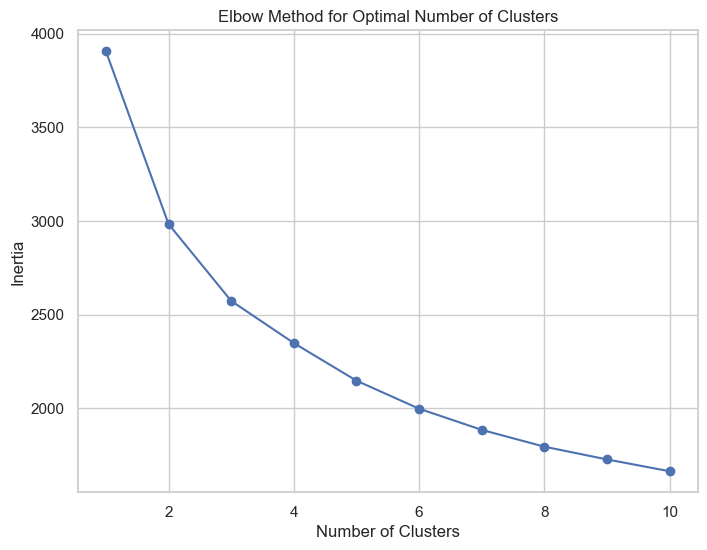

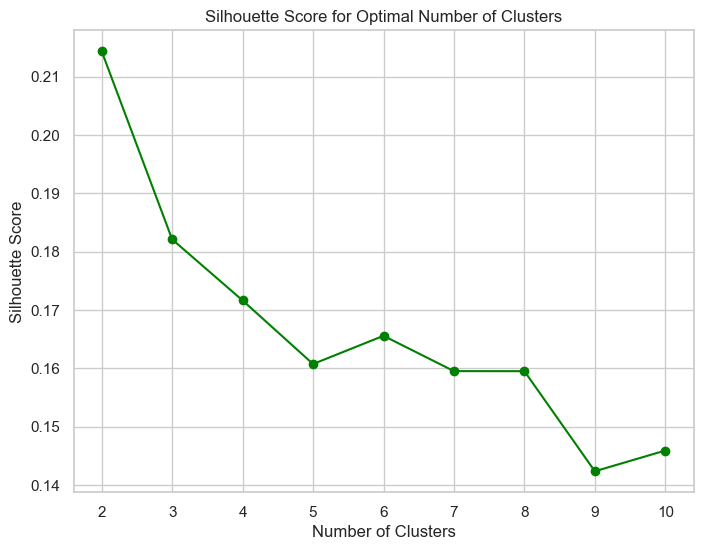

Optimal number of clusters based on Inertia: 2
Optimal number of clusters based on Silhouette Score: 2
Optimal Number of Clusters: 2


In [58]:
optimal_clusters = optimal_number_of_clusters(data, features=['WHR', 'age', 'SBP', 'avg_PRQ', 'avg_stress','avg_deep'], max_clusters=10)
print(f"Optimal Number of Clusters: {optimal_clusters}")


In [66]:
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score

def kmeans_clustering_analysis(data, features, n_clusters=2, target_col=None, random_state=42):
    """
    Performs K-Means clustering on selected features and compares the clusters to a categorical variable.

    Parameters:
        data (pd.DataFrame): The dataset containing independent variables.
        features (list): List of column names to use for clustering.
        n_clusters (int): Number of clusters for K-Means (default: 3).
        target_col (str): Name of the categorical column to compare clusters against (optional).
        random_state (int): Random state for reproducibility (default: 42).

    Returns:
        dict: Contains the model, cluster labels, and evaluation metrics.
    """
    # Extract relevant features and drop NaN values
    X = data[features].dropna().copy()
    
    # Normalize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Add cluster labels to the dataset
    data.loc[X.index, 'Cluster'] = cluster_labels
    
    # If target_col is provided, compare clusters to categorical variable
    if target_col:
        crosstab = pd.crosstab(data.loc[X.index, 'Cluster'], data.loc[X.index, target_col])
        chi2, p_value, _, _ = chi2_contingency(crosstab)
        ari_score = adjusted_rand_score(data.loc[X.index, target_col], cluster_labels)
    else:
        crosstab, chi2, p_value, ari_score = None, None, None, None
    
    # Reduce dimensions using PCA for visualization (if more than 2 features)
    if len(features) > 2:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        data.loc[X.index, 'PCA1'], data.loc[X.index, 'PCA2'] = X_pca[:, 0], X_pca[:, 1]

        # Ensure PCA columns are included in the data used for plotting
        plot_data = data.loc[X.index, ['PCA1', 'PCA2', 'Cluster']]

        # Scatter plot using PCA components
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=plot_data, palette='tab10', alpha=0.7, edgecolor=None)
        plt.title("K-Means Clustering Visualization (PCA-reduced)")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend(title="Cluster")
        plt.show()

    elif len(features) == 2:
        # Scatter plot for 2D feature space
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X[features[0]], y=X[features[1]], hue=data['Cluster'], palette='tab10', alpha=0.7, edgecolor=None)
        plt.title(f"K-Means Clustering on {features}")
        plt.xlabel(features[0])
        plt.ylabel(features[1])
        plt.legend(title="Cluster")
        plt.show()

    # Display results
    print("\nK-Means Clustering Results")
    print(f"Features used: {features}")
    print(f"Number of clusters: {n_clusters}")
    
    if target_col:
        print("\nContingency Table (Clusters vs Target Variable)")
        print(crosstab)
        print(f"\nChi-Square Test: p-value = {p_value:.4f}")
        print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
    
    # Return results
    return {
        "model": kmeans,
        "cluster_labels": cluster_labels,
        "contingency_table": crosstab,
        "chi2_p_value": p_value,
        "ari_score": ari_score
    }


In [68]:

# Perform k-means clustering
result = kmeans_clustering_analysis(data, 
                                    features=['avg_stress', 'avg_deep'], 
                                    n_clusters=2, 
                                    target_col='HSI_cat')


ValueError: Input contains NaN.

In [104]:
!pip install umap-learn

In [110]:
import umap
print(umap.__file__)

/Users/pkalnins/anaconda3/envs/env/lib/python3.9/site-packages/umap/__init__.py


In [111]:
import umap
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

def umap_clustering_analysis(data, features, n_clusters=2, target_col='DM_stat', random_state=42):
    """
    Performs UMAP dimensionality reduction, applies K-Means clustering, and compares clusters with a categorical variable.

    Parameters:
        data (pd.DataFrame): The dataset containing independent variables.
        features (list): List of column names to use for clustering.
        n_clusters (int): Number of clusters for K-Means (default: 2).
        target_col (str): Name of the categorical column to compare clusters against.
        random_state (int): Random state for reproducibility.

    Returns:
        dict: Contains the UMAP coordinates, K-Means model, cluster labels, and evaluation metrics.
    """
    # Extract relevant features and drop NaN values
    X = data[features].dropna().copy()

    # Normalize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform UMAP dimensionality reduction
    umap_model = umap.UMAP(n_components=2, random_state=random_state)
    X_umap = umap_model.fit_transform(X_scaled)

    # Apply K-Means clustering on the reduced space
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(X_umap)

    # Add cluster labels to the dataset
    data['UMAP_Cluster'] = cluster_labels

    # Visualize the UMAP results with clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=cluster_labels, palette='tab10', alpha=0.7, edgecolor=None)
    plt.title("UMAP Clustering Visualization")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.legend(title="Cluster")
    plt.show()

    # Compare clusters to target_col (DM_stat) using Adjusted Rand Index (ARI)
    ari_score = adjusted_rand_score(data[target_col], cluster_labels)

    # Visualize the UMAP results colored by DM_stat
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=data[target_col], palette='coolwarm', alpha=0.7, edgecolor=None)
    plt.title("UMAP Visualization Colored by DM_stat")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.legend(title="DM_stat")
    plt.show()

    # Display results
    print(f"\nAdjusted Rand Index (ARI) between UMAP clusters and DM_stat: {ari_score:.4f}")

    # Return results
    return {
        "umap_model": umap_model,
        "umap_coordinates": X_umap,
        "kmeans_model": kmeans,
        "cluster_labels": cluster_labels,
        "ari_score": ari_score
    }


In [112]:
data = get_data()  # Assume get_data() loads your dataset
result = umap_clustering_analysis(data, features=['WHR', 'age', 'SBP', 'avg_PRQ', 'avg_stress', 'avg_deep'], 
                                  n_clusters=3, target_col='DM_stat')


AttributeError: module 'umap' has no attribute 'UMAP'